# AC Susceptibility Analysis

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

## Data Loading Functions

In [2]:
def extract_metadata_from_filename(filename):
    """Extract sample ID, composition, and field from filename."""
    match = re.search(r'HM(\d+)([A-Za-z0-9]+)_chiAC_vs_T_B_([0-9.]+)', filename)
    if match:
        sample_id = match.group(1)
        composition = match.group(2)
        field_str = match.group(3).rstrip('.')
        
        if field_str.endswith('T'):
            field = float(field_str[:-1])
        else:
            field = float(field_str)
        
        return {
            'sample_id': sample_id,
            'composition': composition,
            'field_tesla': field,
            'full_name': f"HM{sample_id}{composition}"
        }
    return None

def load_ac_susceptibility_file(filepath):
    """Load a single AC susceptibility data file."""
    with open(filepath, 'r') as f:
        lines = f.readlines()
    
    data_start_idx = None
    for i, line in enumerate(lines):
        if 'Lockin_V' in line or 'Chan2_V' in line:
            data_start_idx = i + 1
            break
    
    if data_start_idx is None:
        raise ValueError(f"Could not find data header in {filepath}")
    
    data = pd.read_csv(
        filepath,
        sep='\t',
        skiprows=data_start_idx,
        names=['lockin_v', 'chan2_v', 'temperature', 'field', 'timestamp'],
        engine='python'
    )
    
    metadata = extract_metadata_from_filename(filepath.name)
    if metadata:
        for key, value in metadata.items():
            data[key] = value
    
    data['filepath'] = str(filepath)
    return data

def load_all_ac_data(data_dir='../data/ac_susceptibility'):
    """Load all AC susceptibility files into a single DataFrame."""
    data_path = Path(data_dir)
    all_files = sorted(data_path.rglob('*.txt'))
    
    dataframes = []
    for f in all_files:
        df = load_ac_susceptibility_file(f)
        dataframes.append(df)
    
    combined = pd.concat(dataframes, ignore_index=True)
    return combined

In [3]:
# Load all data
data = load_all_ac_data()
data = data[data['temperature'] <= 10.0]  # Filter to T < 10 K

# Number of data points loaded
len(data)

36055

## Utility Functions

In [4]:
def composition_to_latex(composition):
    """Convert composition string to LaTeX chemical formula."""
    result = ""
    i = 0
    while i < len(composition):
        if i < len(composition) and composition[i].isupper():
            element = composition[i]
            i += 1
            if i < len(composition) and composition[i].islower():
                element += composition[i]
                i += 1
            
            subscript = ""
            while i < len(composition) and composition[i].isdigit():
                subscript += composition[i]
                i += 1
            
            if subscript:
                result += f"{element}$_{{{subscript}}}$"
            else:
                result += element
    
    return result

def trim_high_temp_outliers(field_data, n_trim=3):
    """Remove last n_trim data points to eliminate outliers."""
    if len(field_data) > n_trim:
        return field_data.iloc[:-n_trim]
    return field_data

# Sample order for all plots
# Same order as in paper's table 1
SAMPLE_ORDER = [
    'HM449HfTa4Zr', 'HM451MoTaZr2', 'HM454Nb2TaZr', 'HM455NbTa2Zr',
    'HM457MoNbZr2', 'HM462Hf2Nb3Ru', 'HM463Mo3NbRu2', 'HM464MoNbRu2'
]

## Real Part of Susceptibility

The real part of the AC susceptibility (χ'). Curves are offset to zero at the highest measured temperature.

In [5]:
def plot_real_part_grid(data):
    """Plot real part of susceptibility for all samples in 3x3 grid."""
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()
    
    for idx, sample in enumerate(SAMPLE_ORDER):
        ax = axes[idx]
        sample_data = data[data['full_name'] == sample]
        
        sample_id = sample.split('HM')[1][:3]
        composition = sample.replace(f'HM{sample_id}', '')
        latex_title = composition_to_latex(composition)
        
        needs_trimming = sample in ['HM455NbTa2Zr', 'HM457MoNbZr2']
        
        for field in sorted(sample_data['field_tesla'].unique(), reverse=True):
            field_data = sample_data[sample_data['field_tesla'] == field].sort_values('temperature')
            
            if len(field_data) == 0:
                continue
            
            if needs_trimming and abs(field - 2.0) < 0.1:
                field_data = trim_high_temp_outliers(field_data, n_trim=3)
            
            high_temp_value = field_data.iloc[-1]['lockin_v']
            normalized = (field_data['lockin_v'] - high_temp_value) * 1e6
            
            ax.plot(field_data['temperature'], normalized, 
                   label=f'{field:.1f} T', alpha=0.7, linewidth=1.5)
        
        ax.set_xlabel('Temperature (K)', fontsize=9)
        ax.set_ylabel(r"$\chi'$ offset ($\mu$V)", fontsize=9)
        ax.set_title(latex_title, fontsize=10, fontweight='bold')
        ax.grid(alpha=0.3)
        ax.tick_params(labelsize=8)
    
    # Legend in the empty subplot
    axes[8].axis('off')
    handles, labels = axes[0].get_legend_handles_labels()
    axes[8].legend(handles[::-1], labels[::-1], loc='center', fontsize=12, frameon=False)
    
    plt.tight_layout()
    return fig

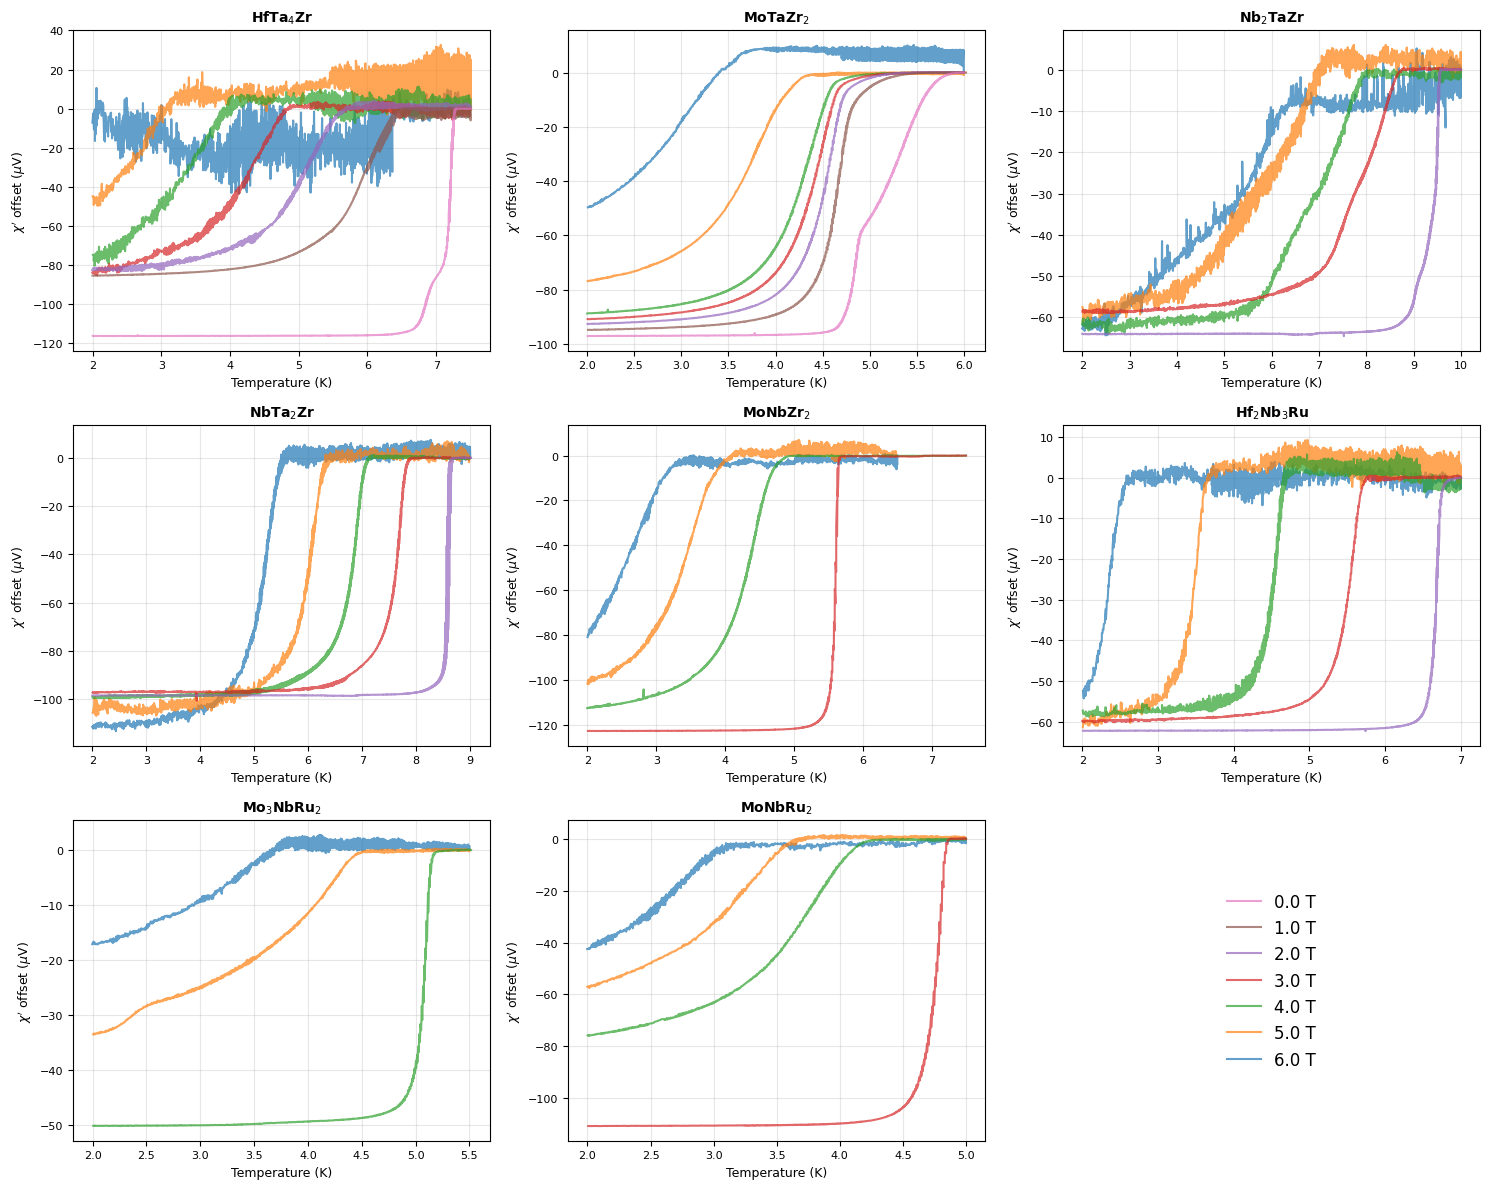

In [6]:
fig_real = plot_real_part_grid(data)
plt.savefig('susceptibility_real_part.pdf', dpi=200, bbox_inches='tight')
plt.show()

## Imaginary Part of Susceptibility

The imaginary part of the AC susceptibility (χ''). A Savitzky-Golay filter (window=31, polynomial order=3) is applied to smooth the data.

In [7]:
def plot_imaginary_part_grid(data, window_length=31, polyorder=3):
    """Plot imaginary part of susceptibility with smoothing for all samples in 3x3 grid."""
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()
    
    for idx, sample in enumerate(SAMPLE_ORDER):
        ax = axes[idx]
        sample_data = data[data['full_name'] == sample]
        
        sample_id = sample.split('HM')[1][:3]
        composition = sample.replace(f'HM{sample_id}', '')
        latex_title = composition_to_latex(composition)
        
        needs_trimming = sample in ['HM455NbTa2Zr', 'HM457MoNbZr2']
        
        for field in sorted(sample_data['field_tesla'].unique(), reverse=True):
            field_data = sample_data[sample_data['field_tesla'] == field].sort_values('temperature')
            
            if len(field_data) == 0:
                continue
            
            if needs_trimming and abs(field - 2.0) < 0.1:
                field_data = trim_high_temp_outliers(field_data, n_trim=3)
            
            if len(field_data) < window_length:
                continue
            
            high_temp_value = field_data.iloc[-1]['chan2_v']
            normalized = (field_data['chan2_v'] - high_temp_value) * 1e6
            smoothed = savgol_filter(normalized, window_length=window_length, polyorder=polyorder)
            
            ax.plot(field_data['temperature'], smoothed, 
                   label=f'{field:.1f} T', alpha=0.7, linewidth=1.5)
        
        ax.set_xlabel('Temperature (K)', fontsize=9)
        ax.set_ylabel(r"$\chi''$ offset ($\mu$V)", fontsize=9)
        ax.set_title(latex_title, fontsize=10, fontweight='bold')
        ax.grid(alpha=0.3)
        ax.tick_params(labelsize=8)
    
    # Legend in the empty subplot
    axes[8].axis('off')
    handles, labels = axes[0].get_legend_handles_labels()
    axes[8].legend(handles[::-1], labels[::-1], loc='center', fontsize=12, frameon=False)
    
    plt.tight_layout()
    return fig

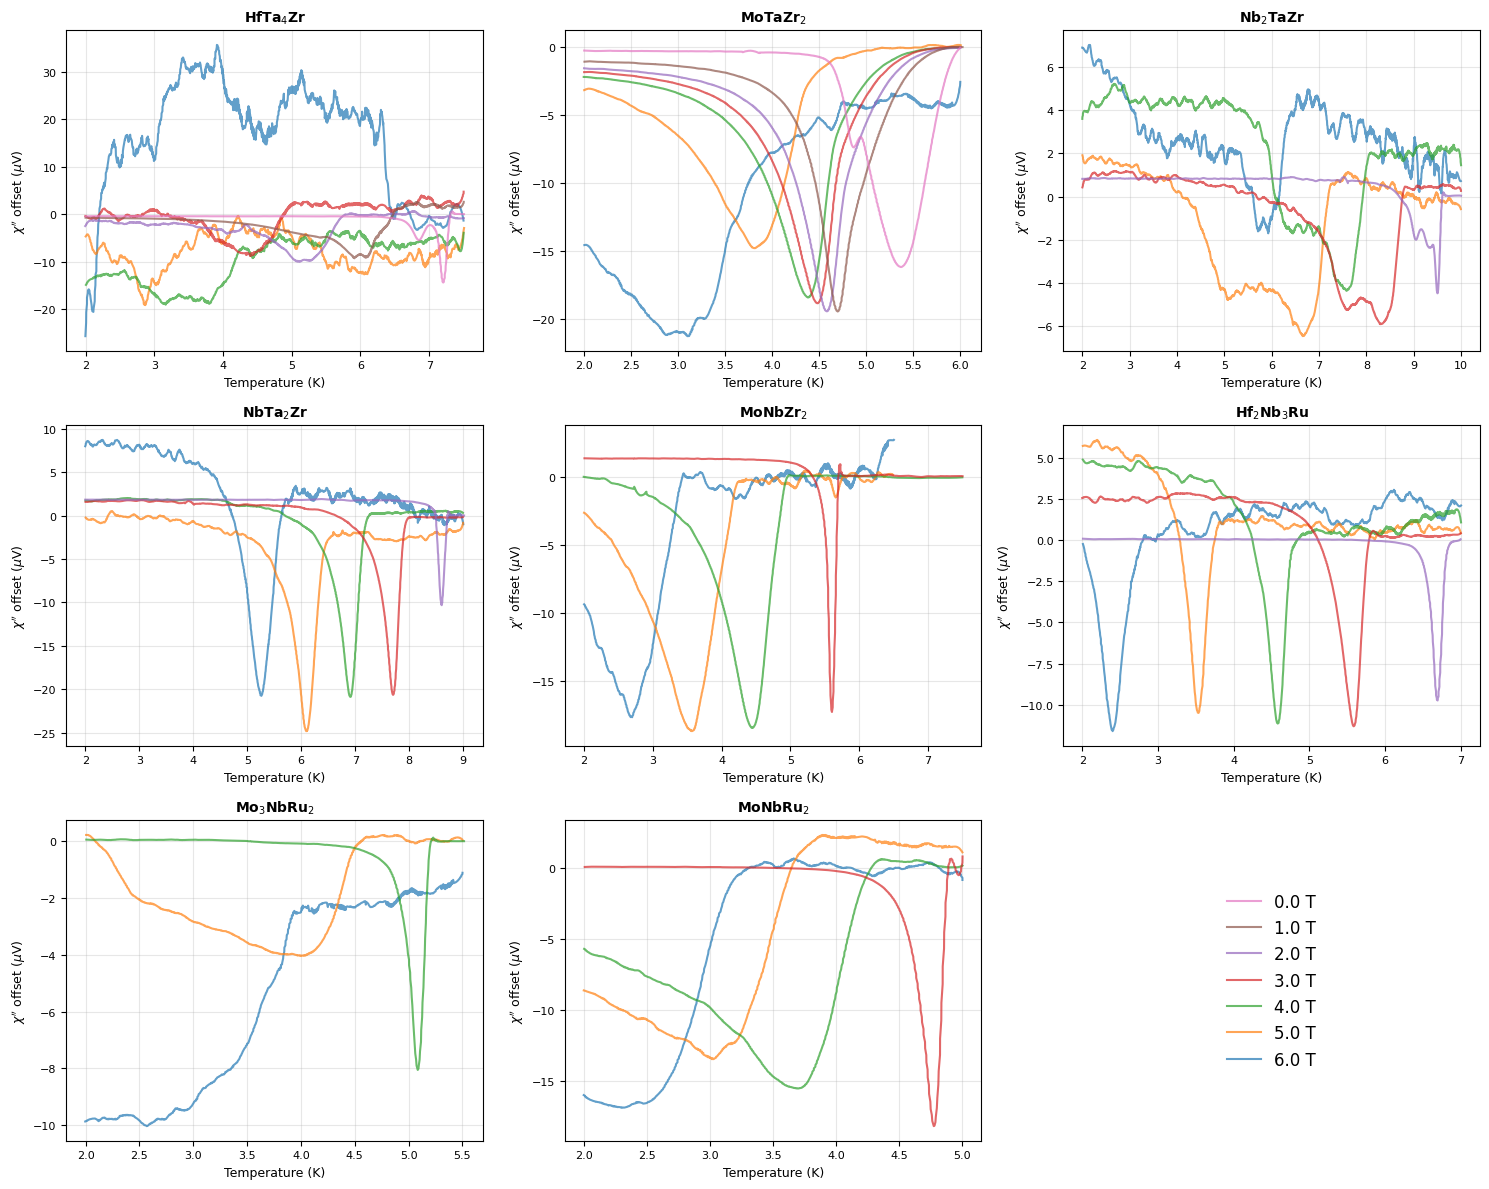

In [8]:
fig_imag = plot_imaginary_part_grid(data)
plt.savefig('susceptibility_imaginary_part.pdf', dpi=200, bbox_inches='tight')
plt.show()

## Critical Temperature Extraction

The critical temperature is extracted from the minimum in the smoothed imaginary part of the susceptibility.

In [9]:
def extract_tc_from_chi_double_prime(field_data, window_length=31, polyorder=3):
    """Extract Tc from the minimum in the imaginary part using smoothing."""
    if len(field_data) < window_length:
        return None
    
    field_data = field_data.sort_values('temperature')
    chi_imag = field_data['chan2_v'].values
    temp = field_data['temperature'].values
    chi_imag_smoothed = savgol_filter(chi_imag, window_length=window_length, polyorder=polyorder)
    min_idx = np.argmin(chi_imag_smoothed)
    tc = temp[min_idx]
    
    return tc

def extract_all_tc_values(data):
    """Extract Tc vs field for all samples."""
    tc_data = []
    
    for sample in SAMPLE_ORDER:
        sample_data = data[data['full_name'] == sample]
        needs_trimming = sample in ['HM455NbTa2Zr', 'HM457MoNbZr2']
        
        for field in sorted(sample_data['field_tesla'].unique()):
            field_data = sample_data[sample_data['field_tesla'] == field].copy()
            
            if len(field_data) == 0:
                continue
            
            if needs_trimming and abs(field - 2.0) < 0.1:
                field_data = trim_high_temp_outliers(field_data, n_trim=3)
            
            tc = extract_tc_from_chi_double_prime(field_data)
            
            if tc is not None:
                tc_data.append({
                    'sample': sample,
                    'field_tesla': field,
                    'tc_kelvin': tc
                })
    
    return pd.DataFrame(tc_data)

In [10]:
# Extract all Tc values
tc_df = extract_all_tc_values(data)

# Number of Tc measurements extracted
len(tc_df)

40

## Upper Critical Field Analysis

We fit the critical field data in two ways.

### Linear

$$H_{c2}(T) = H_{c2}(0) \left(1 - \frac{T}{T_c}\right)$$

### Quadratic

$$H_{c2}(T) = H_{c2}(0) \left[1 - \left(\frac{T}{T_c}\right)^2\right]$$

In [11]:
def linear_model(T, Hc2_0, Tc):
    """Linear model: H(T) = Hc2(0) * (1 - T/Tc)"""
    return Hc2_0 * (1 - T / Tc)

def quadratic_model(T, Hc2_0, Tc):
    """Quadratic model: H(T) = Hc2(0) * (1 - (T/Tc)^2)"""
    return Hc2_0 * (1 - (T / Tc)**2)

def fit_hc2_models(tc_data):
    """Fit both linear and quadratic models to Tc vs field data."""
    T = tc_data['tc_kelvin'].values
    H = tc_data['field_tesla'].values
    
    Tc_guess = T.max()
    Hc2_0_guess = H.max() * 1.5
    
    popt_linear, _ = curve_fit(linear_model, T, H, p0=[Hc2_0_guess, Tc_guess])
    popt_quadratic, _ = curve_fit(quadratic_model, T, H, p0=[Hc2_0_guess, Tc_guess])
    
    return {
        'linear': {'Hc2_0': popt_linear[0], 'Tc': popt_linear[1]},
        'quadratic': {'Hc2_0': popt_quadratic[0], 'Tc': popt_quadratic[1]}
    }

In [12]:
def plot_hc2_grid(tc_df):
    """Plot Hc2(T) with fits for all samples in 3x3 grid."""
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()
    
    fit_results_all = {}
    
    for idx, sample in enumerate(SAMPLE_ORDER):
        ax = axes[idx]
        sample_tc = tc_df[tc_df['sample'] == sample].sort_values('field_tesla')
        
        sample_id = sample.split('HM')[1][:3]
        composition = sample.replace(f'HM{sample_id}', '')
        latex_title = composition_to_latex(composition)
        
        fit_results = fit_hc2_models(sample_tc)
        fit_results_all[composition] = fit_results
        
        max_tc = np.ceil(sample_tc['tc_kelvin'].max())
        max_field_data = sample_tc['field_tesla'].max()
        max_field_fit = max(fit_results['linear']['Hc2_0'], 
                           fit_results['quadratic']['Hc2_0'])
        max_field = np.ceil(max(max_field_data, max_field_fit))
        
        ax.plot(sample_tc['tc_kelvin'], sample_tc['field_tesla'], 
               'o', markersize=8, color='black', label='Data')
        
        T_fit_linear = np.linspace(0, fit_results['linear']['Tc'], 200)
        T_fit_quadratic = np.linspace(0, fit_results['quadratic']['Tc'], 200)
        
        H_linear = linear_model(T_fit_linear, fit_results['linear']['Hc2_0'], 
                               fit_results['linear']['Tc'])
        H_linear = np.clip(H_linear, 0, None)
        ax.plot(T_fit_linear, H_linear, '-', linewidth=2, color='C0', 
               label='Linear', alpha=0.7)
        
        H_quadratic = quadratic_model(T_fit_quadratic, fit_results['quadratic']['Hc2_0'], 
                                     fit_results['quadratic']['Tc'])
        H_quadratic = np.clip(H_quadratic, 0, None)
        ax.plot(T_fit_quadratic, H_quadratic, '--', linewidth=2, color='C1', 
               label='Quadratic', alpha=0.7)
        
        ax.set_xlim(0, max_tc)
        ax.set_ylim(0, max_field)
        ax.set_xlabel('$T_c$ (K)', fontsize=9)
        ax.set_ylabel('Field (T)', fontsize=9)
        ax.set_title(latex_title, fontsize=10, fontweight='bold')
        ax.grid(alpha=0.3)
        ax.tick_params(labelsize=8)
    
    axes[8].axis('off')
    handles, labels = axes[0].get_legend_handles_labels()
    axes[8].legend(handles, labels, loc='center', fontsize=12, frameon=False)
    
    plt.tight_layout()
    return fig, fit_results_all

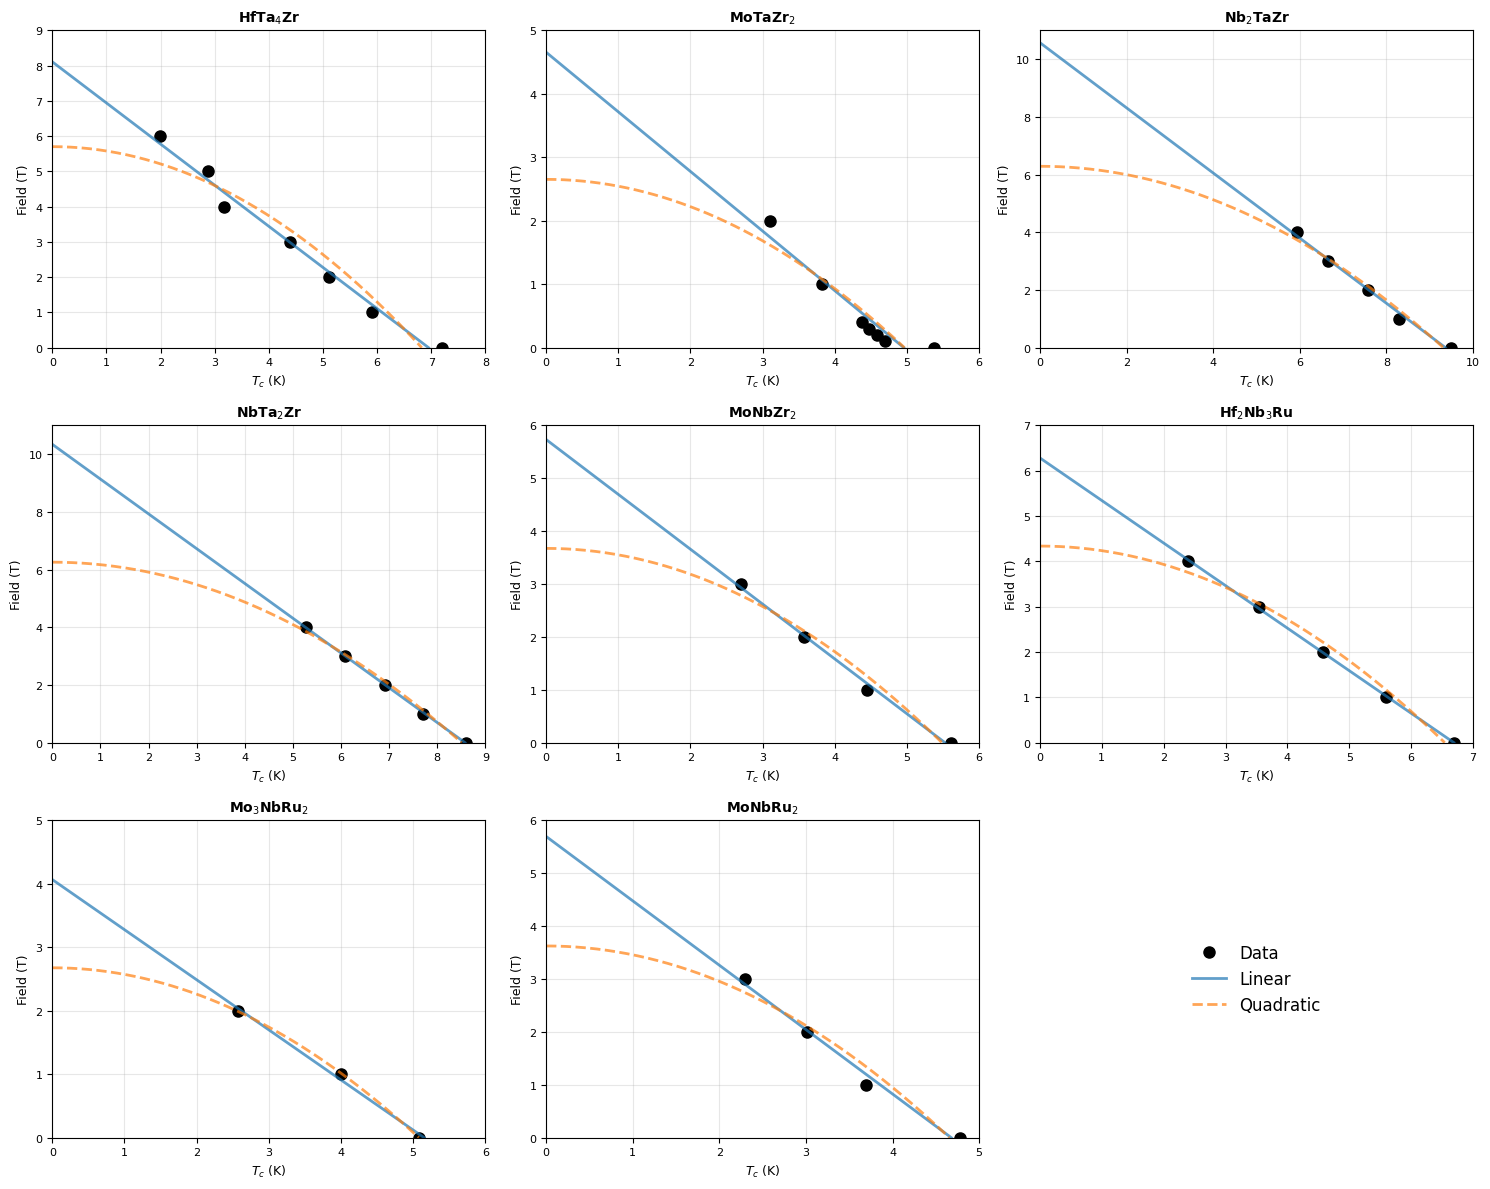

In [13]:
fig_hc2, fit_results = plot_hc2_grid(tc_df)
plt.savefig('hc2_with_fits.pdf', dpi=200, bbox_inches='tight')
plt.show()

## Summary of Fitted Parameters

In [14]:
# Create summary dataframe
summary_data = []
for composition, results in fit_results.items():
    summary_data.append({
        'Composition': composition,
        'Hc2(0) Linear (T)': results['linear']['Hc2_0'],
        'Tc Linear (K)': results['linear']['Tc'],
        'Hc2(0) Quadratic (T)': results['quadratic']['Hc2_0'],
        'Tc Quadratic (K)': results['quadratic']['Tc']
    })

summary_df = pd.DataFrame(summary_data)
summary_df

,Composition,Hc2(0) Linear (T),Tc Linear (K),Hc2(0) Quadratic (T),Tc Quadratic (K)
0,HfTa4Zr,8.107114,6.950365,5.700759,6.824754
1,MoTaZr2,4.654946,4.955283,2.651609,4.964487
2,Nb2TaZr,10.571140,9.362786,6.286900,9.316490
3,NbTa2Zr,10.342631,8.576916,6.255823,8.507527
4,MoNbZr2,5.731987,5.525012,3.673077,5.484337
5,Hf2Nb3Ru,6.280230,6.690609,4.336297,6.542484
6,Mo3NbRu2,4.066646,5.151326,2.676397,5.078260
7,MoNbRu2,5.695459,4.677503,3.624356,4.655716


In [15]:
# Save summary table
summary_df.to_csv('hc2_fit_parameters.csv', index=False)